##### Liam Byrne
##### DATA 620 - Web Analytics
##### Fall - 2017

# Week 10

***

## Introduction
Classification of documents can have many uses; from isolating documents of interest from large corpora to determining origins of texts. This exercise will explore an elementary step in text classification; an email spam filter.

Using the [Spambase Data Set](http://archive.ics.uci.edu/ml/datasets/Spambase) from UCI's Machine Learning Repository, we will built, train and test a few classification models. The data set consists of extracted features (56 features covering things like specific word frequencies, punctuation frequencies and statistics on capital letters) and the emails labeled as either "spam" or "ham" (non-spam emails).

We will first load in our data and import the required packages from Python.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.ensemble import  RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import matplotlib.pyplot as plt
import numpy as np
import re

data_url = "https://raw.githubusercontent.com/Liam-O/Data620/master/Wk10/spambase.data"
head_url = "https://raw.githubusercontent.com/Liam-O/Data620/master/Wk10/spam_ham_header.csv"

# Get headers
spam_ham_headers = pd.read_csv(head_url, header = None)

# Read data to data frame
mail_df = pd.read_csv(data_url, header = None, names = spam_ham_headers[0])

The data will be split into training and testing sets; the latter will receive a conservative 33% holdout from the 4,601 cases. In order to test a few models, a function was created under the following metrics and purpose:

+ Build a classification pipeline to streamline multi-use cases
+ Impute (fill NAs via median) data fit from the training set only (i.e. values of "unseen" data will not affect the transformed median)
+ Plot a normalized confusion matrix
+ Output a classification report of precision, recall and F-score 

In [2]:
X_train, X_test, y_train, y_test = train_test_split(mail_df.iloc[:,:-1], mail_df.spam_ham,
                                                    test_size = 1/3, random_state = 2**7-1)

def model_clf(X_trn, X_tst, Y_trn, Y_tst, clf):
    
    # Pipeline for classification -> will call fit & transform
    # on training data and only transform on test data
    spam_ham_clf = Pipeline([("imp", Imputer(strategy = 'median')),
                        ("clf", clf)])
    
    # Will only impute on training data
    spam_ham_clf.fit(X_trn, Y_trn)
    
    y_pred = spam_ham_clf.predict(X_tst)
    
    conf_matrix = confusion_matrix(
            Y_tst, y_pred)
    
    # Normalize confusion matrix
    cm = conf_matrix.astype('float')/conf_matrix.sum(axis=1)[:, np.newaxis]
    
    # Get name of classifier
    clf_model_name = re.findall('^\w+(?=\()',
                                      np.str(spam_ham_clf.named_steps['clf']))[0]
    
    print("\nConfusion Matrix for {}".format(clf_model_name))
    
    class_names = ["ham", "spam"]
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Normalized Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(0, 2):
        for j in range(0,2):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print("\n\nClassification Report for {}".format(clf_model_name))
    print(classification_report(Y_tst, y_pred, target_names = class_names))

### Random Forest Classification

Our first model will utilize a random forest classifier, which is essentially a very robust decision tree classifier. The random forest classifier will "build" numerous decision trees (with replacement) split on various features and choose the best model.

We will see how a random tree classification is able to predict spam/ham in our testing data below.


Confusion Matrix for RandomForestClassifier


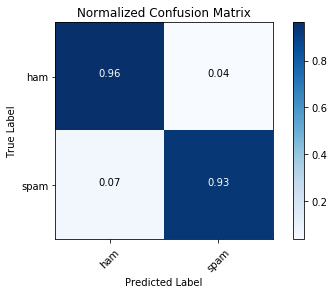



Classification Report for RandomForestClassifier
             precision    recall  f1-score   support

        ham       0.96      0.96      0.96       908
       spam       0.95      0.93      0.94       626

avg / total       0.95      0.95      0.95      1534



In [3]:
rf_clf = RandomForestClassifier(n_estimators=100,
                                max_features=None,
                                n_jobs = -1,
                                random_state = 2**7-1)
model_clf(X_train, X_test, y_train, y_test, rf_clf)

An average F-Score (the harmonic mean of the precision and recall) of 95% is very good for a first try. Let us try another classification model to see if we can improve.

### K Nearest Neighbors Classification

Nearest neighbor classification does not necessarily fit a model. It stores the training data and classifies the testing data by its "closeness" to its neighboring training data. We will use three (3) as the number of neighbors, which means given the test data's features, the algorithm will give the case the dominant classification of the closest three (3) training cases.


Confusion Matrix for KNeighborsClassifier


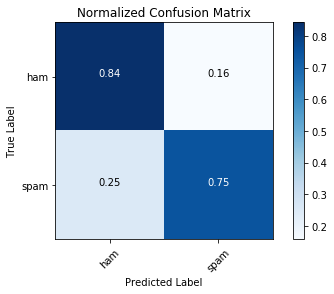



Classification Report for KNeighborsClassifier
             precision    recall  f1-score   support

        ham       0.83      0.84      0.84       908
       spam       0.77      0.75      0.76       626

avg / total       0.80      0.80      0.80      1534



In [4]:
nn_clf = KNeighborsClassifier(n_neighbors = 3, n_jobs = -1)
model_clf(X_train, X_test, y_train, y_test, nn_clf)

The nearest neighbor classification did much worse (~80% F-Score) relative to  our random forest model (95%).

Let's try one more classifier to see if any improvement is possible.

### Support Vector Machines

Support Vector Machines (SVMs) builds a model as points in multidimensional space from the training data. From the gaps between the respective labeled data in this multidimensional space, dividing partitions are created to best group the labeled data. When the test data is introduced, whatever boundary it finds itself in is its resulting classification.


Confusion Matrix for SVC


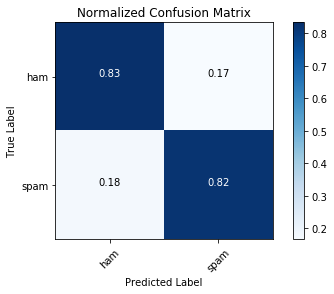



Classification Report for SVC
             precision    recall  f1-score   support

        ham       0.87      0.83      0.85       908
       spam       0.77      0.82      0.80       626

avg / total       0.83      0.83      0.83      1534



In [5]:
svm_clf = svm.SVC(random_state = 2**7-1)
model_clf(X_train, X_test, y_train, y_test, svm_clf)

The SVM classification did much slightly better (~83% F-Score) relative to the Nearest Neighbors Classification (~80% F-Score).

The random forest classification model did by far the best with a ~95% F-Score.